<a id="1"></a> <br>
# 1.Introduction
In this project, you must identify the target of a pronoun within a text passage. The source text is taken from Wikipedia articles. You are provided with the pronoun and two candidate names to which the pronoun could refer. You must create an algorithm capable of deciding whether the pronoun refers to name A, name B, or neither.

The aim of this project is to end the gender bias in pronoun resolution.

<a id="11"></a> <br>
##   1.1 Preparing

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import warnings
import sklearn
import gensim
import scipy
import numpy
import json
import nltk
import sys
import csv
import os

In [2]:
sns.set(style='white', context='notebook', palette='deep')
warnings.filterwarnings('ignore')
sns.set_style('white')
%matplotlib inline

<a id="14"></a> <br>
## 1.2 Import dataset

In [3]:
print(os.listdir("../input/"))
gendered_pronoun_df = pd.read_csv('../input/test_stage_1.tsv', delimiter='\t')
submission = pd.read_csv('../input/sample_submission_stage_1.csv')

['sample_submission_stage_1.csv', 'test_stage_1.tsv', 'sample_submission_stage_2.csv', 'test_stage_2.tsv']


In [4]:
#Get a feel about the raw data
gendered_pronoun_df.shape

(2000, 9)

**Then, we know this dataset contains 2000 rows and 9 attributes**

In [5]:
#let's further invetigate the rows and columns
gendered_pronoun_df.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,URL
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,Pauline,207,http://en.wikipedia.org/wiki/List_of_Teachers_...
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,Bernard Leach,251,http://en.wikipedia.org/wiki/Warren_MacKenzie
2,development-3,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,De la Sota,246,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_...
3,development-4,The current members of Crime have also perform...,his,321,Hell,174,Henry Rosenthal,336,http://en.wikipedia.org/wiki/Crime_(band)
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,Rivera,294,http://en.wikipedia.org/wiki/Jessica_Rivera


<a id="152"></a> <br>
Here are the explanations for each columns or attributes:

1. ID - Unique identifier for an example (Matches to Id in output file format)
1. Text - Text containing the ambiguous pronoun and two candidate names (about a paragraph in length)
1. Pronoun - The target pronoun (text)
1. Pronoun-offset The character offset of Pronoun in Text
1. A - The first name candidate (text)
1. A-offset - The character offset of name A in Text
1. B - The second name candidate
1. B-offset - The character offset of name B in Text
1. URL - The URL of the source Wikipedia page for the example

## 1.3 Check missing data

In [6]:
def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)

In [7]:
check_missing_data(gendered_pronoun_df)

False

**Luckily there is no missing value in this dataset,and we do not need to handle the missing value**

<a id="154"></a> <br>
## 1.4 Statistical Analysis


### 1.4.1 Number of words in the text

In [8]:
gendered_pronoun_df["num_words"] = gendered_pronoun_df["Text"].apply(lambda x: len(str(x).split()))

In [9]:
#Now we calculate the Maximum and Minimum number of words in the Text
print('Maximum number of words in Text is: ',gendered_pronoun_df["num_words"].max())
print('Minimum number of words in Text is:',gendered_pronoun_df["num_words"].min())

Maximum number of words in Text is:  204
Minimum number of words in Text is: 16


### 1.4.2 Number of unique words in the text

In [10]:
gendered_pronoun_df["num_unique_words"] = gendered_pronoun_df["Text"].apply(lambda x: len(set(str(x).split())))
print('Maximum number of unique words in Text is: ',gendered_pronoun_df["num_unique_words"].max())
print('Mean value of unique words in Text is: ',gendered_pronoun_df["num_unique_words"].mean())

Maximum number of unique words in Text is:  136
Mean value of unique words in Text is:  56.4005


### 1.4.3 Number of stopwords in the text

In [11]:
#In computing, stop words are words which are filtered out before processing of natural language data. 
#This step, the Natural Language Toolkit (NLTK) will be used to investigate the stopwords
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))
gendered_pronoun_df["num_stopwords"] = gendered_pronoun_df["Text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

In [12]:
#Now let's calculate the maximum number of stop words
print('Maximum number of stopwords in Text is: ',gendered_pronoun_df["num_stopwords"].max())

Maximum number of stopwords in Text is:  88


### 1.4.4 Code the pronoun

In [13]:
#Let's investigate what are the pronouns 
pronoun=gendered_pronoun_df["Pronoun"]
np.unique(pronoun)

array(['He', 'Her', 'His', 'She', 'he', 'her', 'him', 'his', 'she'],
      dtype=object)

In [14]:
## Now we code the pronoun so that we can make further analysis
binary = {
    "He": 0,
    "he": 0,
    "She": 1,
    "she": 1,
    "His": 2,
    "his": 2,
    "Him": 3,
    "him": 3,
    "Her": 4,
    "her": 4
}
for index in range(len(gendered_pronoun_df)):
    key = gendered_pronoun_df.iloc[index]['Pronoun']
    gendered_pronoun_df.at[index, 'Pronoun_binary'] = binary[key]
gendered_pronoun_df.head(30)

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,URL,num_words,num_unique_words,num_stopwords,Pronoun_binary
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,Pauline,207,http://en.wikipedia.org/wiki/List_of_Teachers_...,74,61,29,4.0
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,Bernard Leach,251,http://en.wikipedia.org/wiki/Warren_MacKenzie,65,58,22,2.0
2,development-3,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,De la Sota,246,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_...,95,71,39,2.0
3,development-4,The current members of Crime have also perform...,his,321,Hell,174,Henry Rosenthal,336,http://en.wikipedia.org/wiki/Crime_(band),69,58,24,2.0
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,Rivera,294,http://en.wikipedia.org/wiki/Jessica_Rivera,112,80,43,1.0
5,development-6,Sandra Collins is an American DJ. She got her ...,She,411,Collins,236,DJ,347,http://en.wikipedia.org/wiki/Sandra_Collins,81,64,31,1.0
6,development-7,Reb Chaim Yaakov's wife is the sister of Rabbi...,his,273,Reb Asher,152,Akiva Eiger,253,http://en.wikipedia.org/wiki/Asher_Arieli,72,48,27,2.0
7,development-8,Slant Magazine's Sal Cinquemani viewed the alb...,his,337,Greg Kot,173,Robert Christgau,377,http://en.wikipedia.org/wiki/The_Truth_About_L...,71,60,26,2.0
8,development-9,Her father was an Englishman ``of rank and cul...,her,246,Mary Paine,255,Kelsey,267,http://en.wikipedia.org/wiki/Mary_S._Peake,53,42,23,4.0
9,development-10,Shaftesbury's UK partners in the production of...,she,329,Christina Jennings,196,Kirstine Stewart,226,http://en.wikipedia.org/wiki/Murdoch_Mysteries,52,45,16,1.0


## 1.5 Exploratory visualization

### 1.5.1 WordCloud

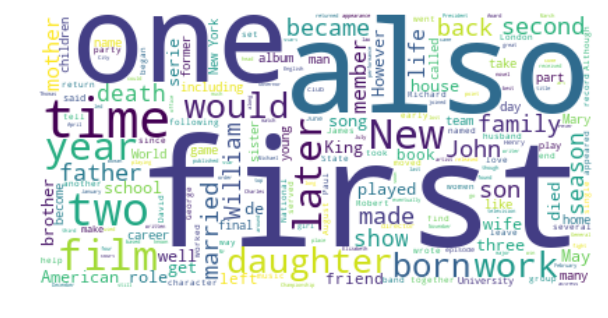

In [15]:
from wordcloud import WordCloud as wc
from nltk.corpus import stopwords
def generate_wordcloud(text): 
    wordcloud = wc(relative_scaling = 1.0,stopwords = eng_stopwords, background_color = 'white').generate(text)
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.margins(x=0, y=0)
    plt.show()
    
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))

text =" ".join(gendered_pronoun_df.Text)
generate_wordcloud(text)

**There are some words which we can make inference about their gender:**
* daughter
* father
* son
* wife
* mother
* brother
* Mary
* William


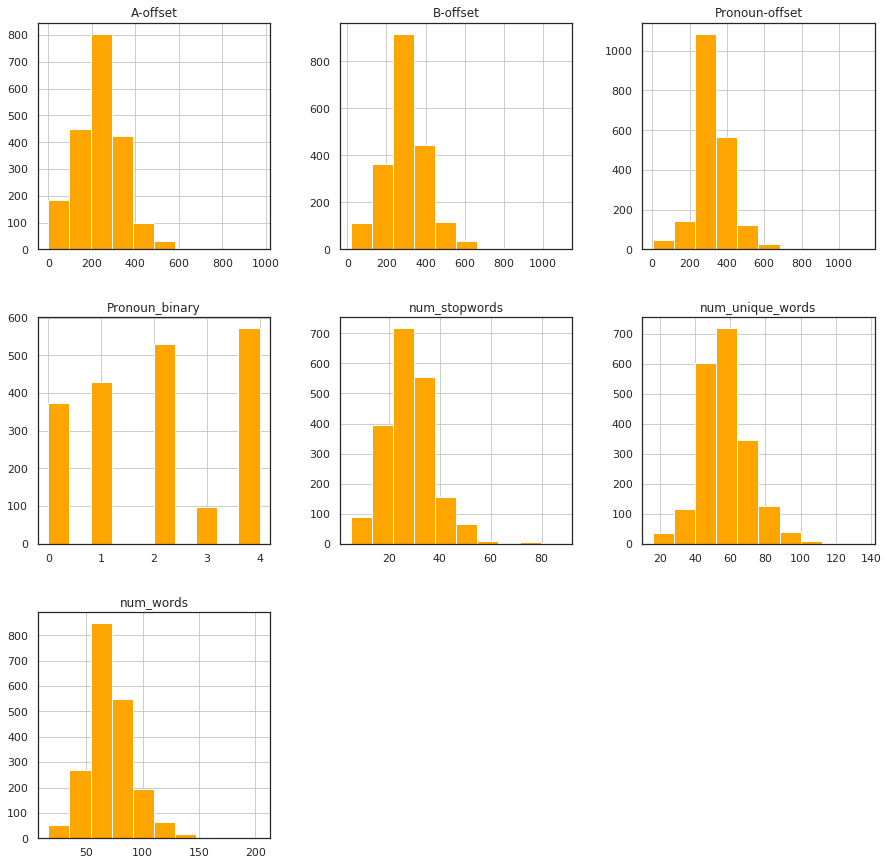

In [16]:
gendered_pronoun_df.hist(color = 'orange',figsize=(15,15));

**From the Pronoun binary, we can find that Him/him are mentioned least**

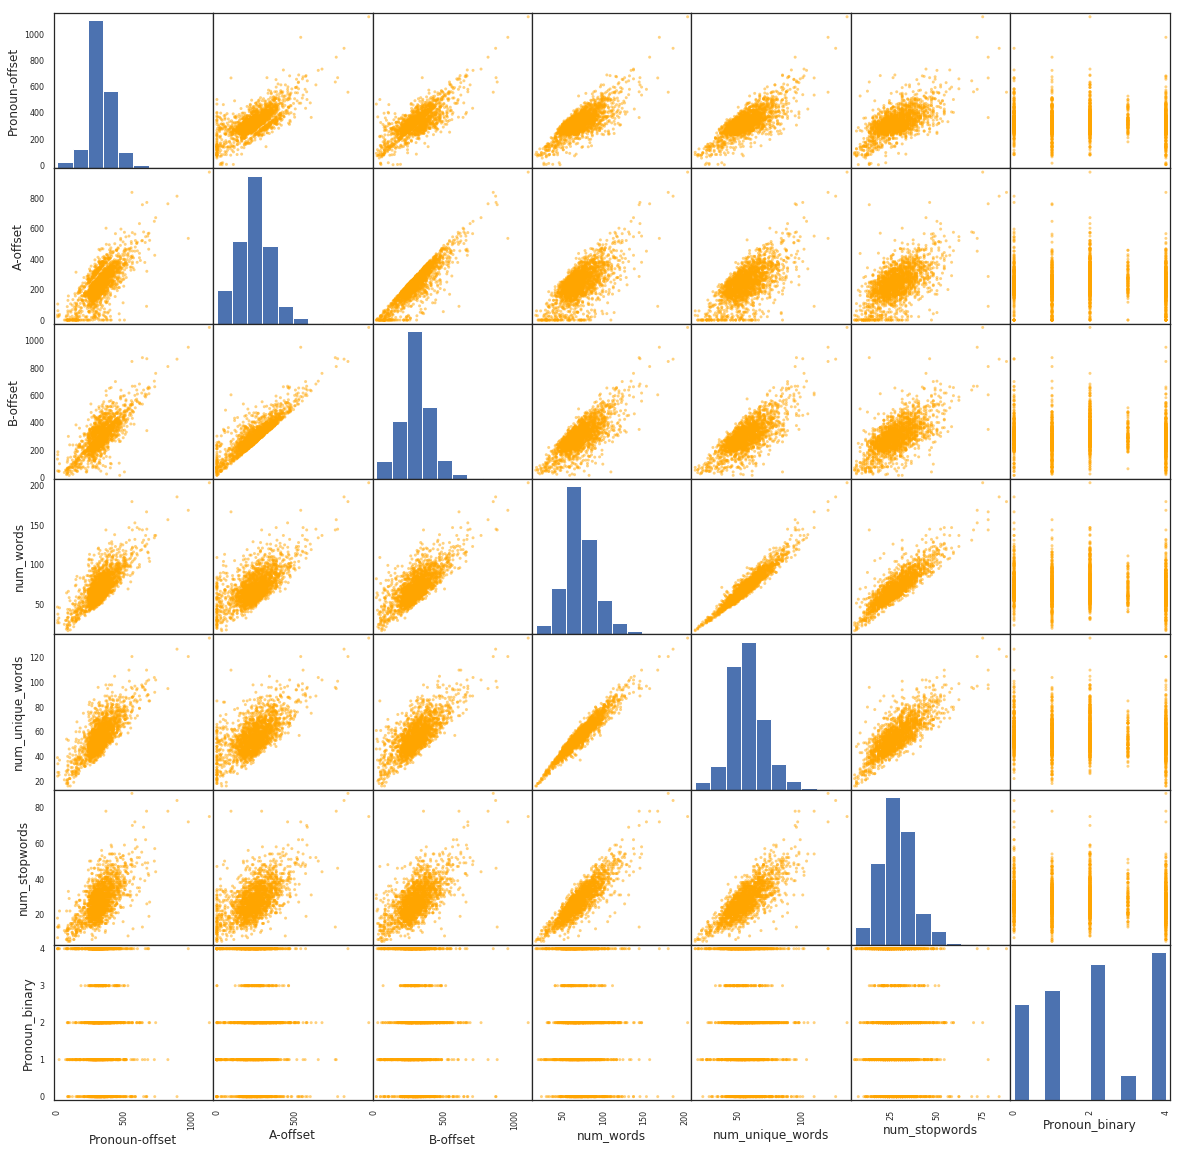

<Figure size 432x288 with 0 Axes>

In [17]:
pd.plotting.scatter_matrix(gendered_pronoun_df,color = 'orange',figsize=(20,20))
plt.figure();

**So we can find that there is a linear relationship among [pronoun-offset,A-offset,B-offset,num_words,num_unique_words,num_stopwprds]**


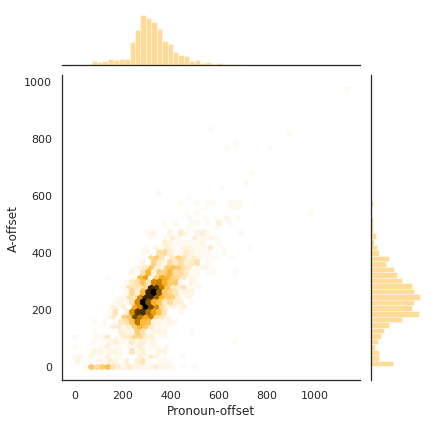

In [18]:
#**Now let's zoom in and further visualize the relationship between pronoun-offset and A-offset**
sns.jointplot(x='Pronoun-offset',y='A-offset',data=gendered_pronoun_df, kind='hex', color ='orange')

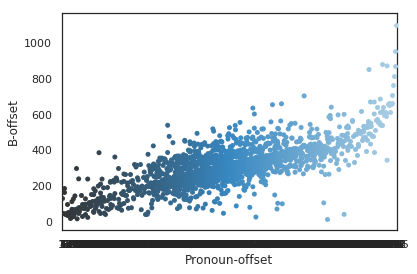

In [19]:
#Now let's visualize the relationship between pronoun-offset and B-offset**
sns.swarmplot(x='Pronoun-offset',y='B-offset',data=gendered_pronoun_df,palette = "Blues_d");

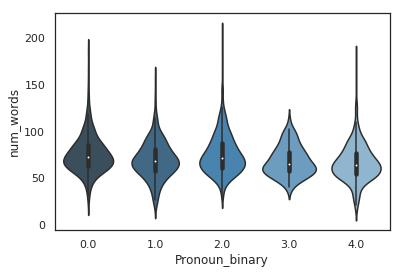

In [20]:
sns.violinplot(data=gendered_pronoun_df,x="Pronoun_binary", y="num_words", palette = "Blues_d")

<a id="2"></a> <br>
# 2.Natural Language Processing 
Now we are going to use the Natural Language Toolkit (NLTK) to do some NLP work

## 2.1 Tokenize

In [21]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [22]:
#first, choose the first row if the Text 
our_text=gendered_pronoun_df.Text[0]
#Then, let's tokenize the text by word and store the result to variable 'words'
words = word_tokenize(our_text)
#Let's tokenize the text by sentence and store the result to variable 'phrases'
phrases = sent_tokenize(our_text)

In [23]:
#print them
print(words)

['Zoe', 'Telford', '--', 'played', 'the', 'police', 'officer', 'girlfriend', 'of', 'Simon', ',', 'Maggie', '.', 'Dumped', 'by', 'Simon', 'in', 'the', 'final', 'episode', 'of', 'series', '1', ',', 'after', 'he', 'slept', 'with', 'Jenny', ',', 'and', 'is', 'not', 'seen', 'again', '.', 'Phoebe', 'Thomas', 'played', 'Cheryl', 'Cassidy', ',', 'Pauline', "'s", 'friend', 'and', 'also', 'a', 'year', '11', 'pupil', 'in', 'Simon', "'s", 'class', '.', 'Dumped', 'her', 'boyfriend', 'following', 'Simon', "'s", 'advice', 'after', 'he', 'would', "n't", 'have', 'sex', 'with', 'her', 'but', 'later', 'realised', 'this', 'was', 'due', 'to', 'him', 'catching', 'crabs', 'off', 'her', 'friend', 'Pauline', '.']


In [24]:
print(phrases)

['Zoe Telford -- played the police officer girlfriend of Simon, Maggie.', 'Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again.', "Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class.", "Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline."]


<a id="23"></a> <br>
## 2.3 Stop Words
In this step, we are going to filter the stop words in the text

In [25]:
from nltk.corpus import stopwords

In [26]:
stopWords = set(stopwords.words('english'))
words = word_tokenize(our_text)
new_words = []

for w in words:
    if w not in stopWords:
        new_words.append(w)
 
print(new_words)

['Zoe', 'Telford', '--', 'played', 'police', 'officer', 'girlfriend', 'Simon', ',', 'Maggie', '.', 'Dumped', 'Simon', 'final', 'episode', 'series', '1', ',', 'slept', 'Jenny', ',', 'seen', '.', 'Phoebe', 'Thomas', 'played', 'Cheryl', 'Cassidy', ',', 'Pauline', "'s", 'friend', 'also', 'year', '11', 'pupil', 'Simon', "'s", 'class', '.', 'Dumped', 'boyfriend', 'following', 'Simon', "'s", 'advice', 'would', "n't", 'sex', 'later', 'realised', 'due', 'catching', 'crabs', 'friend', 'Pauline', '.']


Great!After filtering the stop words,we compressed text

<a id="24"></a> <br>
## 2.4 Stemming
Stemming is the process of producing morphological variants of a root/base word. 
For example, after stemming, eating, eaten, ate, eats, eatings will be shown as **eat**

In [27]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()
 
for word in word_tokenize(our_text):
    print(ps.stem(word))

zoe
telford
--
play
the
polic
offic
girlfriend
of
simon
,
maggi
.
dump
by
simon
in
the
final
episod
of
seri
1
,
after
he
slept
with
jenni
,
and
is
not
seen
again
.
phoeb
thoma
play
cheryl
cassidi
,
paulin
's
friend
and
also
a
year
11
pupil
in
simon
's
class
.
dump
her
boyfriend
follow
simon
's
advic
after
he
would
n't
have
sex
with
her
but
later
realis
thi
wa
due
to
him
catch
crab
off
her
friend
paulin
.


<a id="25"></a> <br>
## 2.5 Speech tagging
Speech Tagging can label words such as verbs, nouns and so on.

In [28]:
import nltk
from nltk.tokenize import PunktSentenceTokenizer

sentences = nltk.sent_tokenize(our_text)   
for sent in sentences:
    print(nltk.pos_tag(nltk.word_tokenize(sent)))

[('Zoe', 'NNP'), ('Telford', 'NNP'), ('--', ':'), ('played', 'VBD'), ('the', 'DT'), ('police', 'NN'), ('officer', 'NN'), ('girlfriend', 'NN'), ('of', 'IN'), ('Simon', 'NNP'), (',', ','), ('Maggie', 'NNP'), ('.', '.')]
[('Dumped', 'VBN'), ('by', 'IN'), ('Simon', 'NNP'), ('in', 'IN'), ('the', 'DT'), ('final', 'JJ'), ('episode', 'NN'), ('of', 'IN'), ('series', 'NN'), ('1', 'CD'), (',', ','), ('after', 'IN'), ('he', 'PRP'), ('slept', 'VBD'), ('with', 'IN'), ('Jenny', 'NNP'), (',', ','), ('and', 'CC'), ('is', 'VBZ'), ('not', 'RB'), ('seen', 'VBN'), ('again', 'RB'), ('.', '.')]
[('Phoebe', 'NNP'), ('Thomas', 'NNP'), ('played', 'VBD'), ('Cheryl', 'NNP'), ('Cassidy', 'NNP'), (',', ','), ('Pauline', 'NNP'), ("'s", 'POS'), ('friend', 'NN'), ('and', 'CC'), ('also', 'RB'), ('a', 'DT'), ('year', 'NN'), ('11', 'CD'), ('pupil', 'NN'), ('in', 'IN'), ('Simon', 'NNP'), ("'s", 'POS'), ('class', 'NN'), ('.', '.')]
[('Dumped', 'NNP'), ('her', 'PRP$'), ('boyfriend', 'NN'), ('following', 'VBG'), ('Simon', 'N

After speech tagging, we can choose the words based on their type

In [29]:
import nltk
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer

sentences = nltk.sent_tokenize(our_text)   
data = []
for sent in sentences:
    data = data + nltk.pos_tag(nltk.word_tokenize(sent))

# Now let's choose Pronoun
for word in data: 
    if 'PRP' in word[1]: 
        print(word)

('he', 'PRP')
('her', 'PRP$')
('he', 'PRP')
('her', 'PRP$')
('him', 'PRP')
('her', 'PRP$')
